In [7]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Data Handling and Processing
import numpy as np
import pandas as pd
import math
from sklearn.impute import KNNImputer
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import viztoolz as viz
import mltoolz as mlt
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Model Selection, Metrics & Evaluation
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFE, SelectPercentile, mutual_info_classif, SelectKBest
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, ConfusionMatrixDisplay
import phik
from phik import resources, report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier, VotingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Pipeline Construction 
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Model Handling
import joblib
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

---
---
## Load train and prediction set

In [8]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

print('-'*16)
print(f'Train Set Shape:\n{train.shape}')
print('-'*16)
print(f'Test Set Shape:\n{test.shape}')
print('-'*16)

----------------
Train Set Shape:
(8693, 14)
----------------
Test Set Shape:
(4277, 13)
----------------


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


---
---
## Define custom classes to handle data processing

In [10]:
# Transform PassengerId into InGroup and GroupSize
class transformPassengerId(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X['GroupId'] = X['PassengerId'].str.split('_').str[0]
        X['PassengerNumber'] = X['PassengerId'].str.split('_').str[1].astype(float)
        group_counts = X['GroupId'].value_counts()
        X['GroupSize'] = X['GroupId'].map(group_counts)
        X['InGroup'] = np.where(X['GroupSize'] > 1, 1, 0)
        return X


# Transform Cabin into Deck, CabinPosition and Side 
class transformCabin(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X['Deck'] = X['Cabin'].str.split('/').str[0]
        X['CabinNumber'] = X['Cabin'].str.split('/').str[1].astype(float)
        X['Side'] = X['Cabin'].str.split('/').str[2]
        bin_edges = np.linspace(X['CabinNumber'].min(), X['CabinNumber'].max(), 5)
        X['CabinPosition'] = pd.cut(X['CabinNumber'],
                                    bins=bin_edges,
                                    labels=['Front','Second','Third','Back'],
                                    include_lowest=True)
        return X


# Impute HomePlanet
class imputeHomePlanet(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.group_modes = None
        self.deck_modes = None
        self.global_mode = None

    def fit(self, X, y=None):
        X = X.copy()
        self.group_modes = (X.groupby('GroupId')['HomePlanet'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None))
        self.deck_modes = (X.groupby('Deck')['HomePlanet'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None))
        self.global_mode = X['HomePlanet'].mode().iloc[0]
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        if self.group_modes is not None:
            X.loc[X['HomePlanet'].isna(), 'HomePlanet'] = (X.loc[X['HomePlanet'].isna(), 'GroupId'].map(self.group_modes))
        if self.deck_modes is not None:
            X.loc[X['HomePlanet'].isna(), 'HomePlanet'] = (X.loc[X['HomePlanet'].isna(), 'Deck'].map(self.deck_modes))
        X['HomePlanet'].fillna(self.global_mode, inplace=True)
        return X


# Create proportional imputer and impute
class proportionalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, impute_cols=None, group_col='HomePlanet'):
        self.impute_cols = impute_cols or ['Destination', 'Deck', 'Side', 'CabinPosition', 'VIP', 'CryoSleep']
        self.group_col = group_col
        self.proportions = {}

    def fit(self, X, y=None):
        X = X.copy()
        self.proportions = {}
        
        for col in self.impute_cols:
            self.proportions[col] = (X.groupby(self.group_col)[col].value_counts(normalize=True).dropna())
        return self

    def transform(self, X, y=None):
        X = X.copy()
        
        for col in self.impute_cols:
            col_proportions = self.proportions.get(col, None)

            if col_proportions is not None:
                def map_group(row):
                    group = row[self.group_col]
                    if pd.isna(row[col]) and pd.notna(group) and group in col_proportions.index:
                        group_proportions = col_proportions.loc[group]
                        return np.random.choice(group_proportions.index, p=group_proportions.values)
                    return row[col]

                X[col] = X.apply(map_group, axis=1)
        return X


# KNN Imputer and transformer
class KNNImputerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
        self.imputer = KNNImputer(n_neighbors=5)
        self.imputer.fit(X[self.columns])
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X[self.columns] = self.imputer.transform(X[self.columns])
        return X


# Create TotalSpent column
class createTotalSpent(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X['TotalSpent'] = X[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
        return X

    
# Creates binary feature of each service_used
class createServiceUsed(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols or ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        for col in self.cols:
            X[f'{col}_used'] = X[col].apply(lambda x: 1 if x > 0 else 0).astype(int)
        
        return X

# Creates binary feature that marks outliers for each service
class createBigSpenders(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols or ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpent']
        self.iqr_limits = {}

    def fit(self, X, y=None):
        X = X.copy()
        self.iqr_limits = {col: X[col].quantile(0.75) + 1.5 * (X[col].quantile(0.75) - X[col].quantile(0.25)) for col in self.cols}
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        for col in self.cols:
            outlier_limit = self.iqr_limits[col]
            X[f'{col}_big_spender'] = X[col].apply(lambda x: 1 if x > outlier_limit else 0).astype(int)
        return X


# Convert binary classes to int 
class toInt(BaseEstimator, TransformerMixin):
    def __init__(self, int_cols=None):
        self.int_cols = int_cols

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        for col in self.int_cols:
            if col in X.columns:
                X[col] = X[col].astype(int)
        return X


# Create a phik feature selector
class phikFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, target, threshold=0.2, feature_names=None):
        self.target = target
        self.threshold = threshold
        self.feature_names = feature_names
        self.selected_feature_idxs = []

    def fit(self, X, y=None):
        X = X.copy()
        X = pd.DataFrame(X, columns=self.feature_names)
        X['target'] = y
        phik_matrix = X.phik_matrix()

        selected_features = phik_matrix[self.target][phik_matrix[self.target] > self.threshold].index.tolist()
        if self.target in selected_features:
            selected_features.remove(self.target)

        self.selected_feature_idxs = [self.feature_names.index(feat) for feat in selected_features]
        
        return self
    
    def transform(self, X, y=None):
        return X[:, self.selected_feature_idxs]


# Drop unwanted columns
class dropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, drop_cols=None):
        self.drop_cols = drop_cols

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        if self.drop_cols:
            X.drop(columns=self.drop_cols, inplace=True, errors='ignore')
        return X

---
---
## Split train into X, y pairs and train, validation sets

In [11]:
target = 'Transported'

train = shuffle(train, random_state=42)
train, val = train_test_split(train, test_size=0.3, stratify=train[target], random_state=42)

X_train, y_train = train.drop(target, axis=1), train[target]
X_val, y_val = val.drop(target, axis=1), val[target]

---
---
## Instantiate base algorithms

In [12]:
binary_cols_1 = ['InGroup','VIP','CryoSleep']
binary_cols_2 = ['InGroup','VIP','CryoSleep','RoomService_used','FoodCourt_used','ShoppingMall_used','Spa_used','VRDeck_used']
binary_cols_3 = ['InGroup','VIP','CryoSleep','RoomService_big_spender','FoodCourt_big_spender','ShoppingMall_big_spender','Spa_big_spender','VRDeck_big_spender, TotalSpent_big_spender']
binary_cols_4 = ['InGroup','VIP','CryoSleep','RoomService_used','FoodCourt_used','ShoppingMall_used','Spa_used','VRDeck_used','RoomService_big_spender','FoodCourt_big_spender','ShoppingMall_big_spender','Spa_big_spender','VRDeck_big_spender, TotalSpent_big_spender']

num_cols_1 = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalSpent']
num_cols_2 = ['Age','TotalSpent']

cat_cols_1 = ['HomePlanet','Destination','Deck','Side','CabinPosition','GroupSize','InGroup','VIP','CryoSleep','GroupSize']
cat_cols_2 = ['HomePlanet','Destination','Deck','Side','CabinPosition','GroupSize']

droppers_1 = ['PassengerId','PassengerNumber','GroupId','Cabin','CabinNumber','Name']
droppers_2 = ['PassengerId','PassengerNumber','GroupId','Cabin','CabinNumber','Name','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

all_features = ['PassengerId','HomePlanet','CryoSleep','Destination','Age','VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Transported','GroupSize','InGroup','Deck','Side','CabinPosition','TotalSpent','RoomService_used','RoomService_big_spender','FoodCourt_used','FoodCourt_big_spender','ShoppingMall_used','ShoppingMall_big_spender','Spa_used','Spa_big_spender','VRDeck_used','VRDeck_big_spender','TotalSpent_big_spender']
phik_selection = ['CryoSleep','RoomService_used','Spa_used','VRDeck_used','Spa_big_spender','RoomService_big_spender','VRDeck_big_spender','ShoppingMall_used','FoodCourt_used','Deck','Spa','ShoppingMall_big_spender','RoomService','VRDeck']

phik_selectOrder = [col for col in all_features if col in phik_selection]
phik_droppers = [col for col in all_features if col not in phik_selection] + droppers_1

binary_cols_phik = [col for col in binary_cols_4 if col in phik_selection]
num_cols_phik = [col for col in num_cols_1 if col in phik_selection]
cat_cols_phik = [col for col in cat_cols_2 if col in phik_selection]

Base algorithms

In [13]:
lr = LogisticRegression(C=1, max_iter=1000)
svc = SVC(C=1, kernel='sigmoid', gamma='scale')

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
lgbm = LGBMClassifier(n_estimators=100, max_depth=5, verbose=-1, random_state=42)
xgbm = XGBClassifier(n_estimators=100, max_depth=5, random_state=42)
catb = CatBoostClassifier(iterations=100, depth=5, cat_features=cat_cols_2, l2_leaf_reg=2, verbose=0)

base_algs = {'lr':lr, 'svc':svc, 'rf':rf, 'lgbm':lgbm, 'xgbm':xgbm, 'catb':catb}

---
---
## Build base pipeline

- Pipelines provide the best workflow to avoid data leakage from the training folds into the validation folds during cross validation.
- Going to test out several pipelines using cross validation to see which selection of features has the best performance

In [14]:
# Preprocess pipelines
preprocess_1 = Pipeline([
    ('TransformPassengerId', transformPassengerId()),
    ('TransformCabin', transformCabin()),
    ('ImputeHomePlanet', imputeHomePlanet()),
    ('ProportionalImputer', proportionalImputer()),
    ('KNNImputer', KNNImputerTransformer()),
    ('CreateTotalSpent', createTotalSpent()),
    ('ToInt', toInt(int_cols=binary_cols_1)),
    ('DropColumns', dropColumns(drop_cols=droppers_1))
])

preprocess_2 = Pipeline([
    ('TransformPassengerId', transformPassengerId()),
    ('TransformCabin', transformCabin()),
    ('ImputeHomePlanet', imputeHomePlanet()),
    ('ProportionalImputer', proportionalImputer()),
    ('KNNImputer', KNNImputerTransformer()),
    ('CreateTotalSpent', createTotalSpent()),
    ('CreateServiceUsed', createServiceUsed()),
    ('ToInt', toInt(int_cols=binary_cols_2)),
    ('DropColumns', dropColumns(drop_cols=droppers_1))
])

preprocess_3 = Pipeline([
    ('TransformPassengerId', transformPassengerId()),
    ('TransformCabin', transformCabin()),
    ('ImputeHomePlanet', imputeHomePlanet()),
    ('ProportionalImputer', proportionalImputer()),
    ('KNNImputer', KNNImputerTransformer()),
    ('CreateTotalSpent', createTotalSpent()),
    ('CreateServiceUsed', createServiceUsed()),
    ('ToInt', toInt(int_cols=binary_cols_2)),
    ('DropColumns', dropColumns(drop_cols=droppers_2))
])

preprocess_4 = Pipeline([
    ('TransformPassengerId', transformPassengerId()),
    ('TransformCabin', transformCabin()),
    ('ImputeHomePlanet', imputeHomePlanet()),
    ('ProportionalImputer', proportionalImputer()),
    ('KNNImputer', KNNImputerTransformer()),
    ('CreateTotalSpent', createTotalSpent()),
    ('CreateBigSpenders', createBigSpenders()),
    ('ToInt', toInt(int_cols=binary_cols_3)),
    ('DropColumns', dropColumns(drop_cols=droppers_1))
])

preprocess_5 = Pipeline([
    ('TransformPassengerId', transformPassengerId()),
    ('TransformCabin', transformCabin()),
    ('ImputeHomePlanet', imputeHomePlanet()),
    ('ProportionalImputer', proportionalImputer()),
    ('KNNImputer', KNNImputerTransformer()),
    ('CreateTotalSpent', createTotalSpent()),
    ('CreateBigSpenders', createBigSpenders()),
    ('ToInt', toInt(int_cols=binary_cols_3)),
    ('DropColumns', dropColumns(drop_cols=droppers_2))
])

preprocess_6 = Pipeline([
    ('TransformPassengerId', transformPassengerId()),
    ('TransformCabin', transformCabin()),
    ('ImputeHomePlanet', imputeHomePlanet()),
    ('ProportionalImputer', proportionalImputer()),
    ('KNNImputer', KNNImputerTransformer()),
    ('CreateTotalSpent', createTotalSpent()),
    ('CreateServiceUsed', createServiceUsed()),
    ('CreateBigSpenders', createBigSpenders()),
    ('ToInt', toInt(int_cols=binary_cols_4)),
    ('DropColumns', dropColumns(drop_cols=droppers_1))
])

preprocess_7 = Pipeline([
    ('TransformPassengerId', transformPassengerId()),
    ('TransformCabin', transformCabin()),
    ('ImputeHomePlanet', imputeHomePlanet()),
    ('ProportionalImputer', proportionalImputer()),
    ('KNNImputer', KNNImputerTransformer()),
    ('CreateTotalSpent', createTotalSpent()),
    ('CreateServiceUsed', createServiceUsed()),
    ('CreatebigSpenders', createBigSpenders()),
    ('ToInt', toInt(int_cols=binary_cols_4)),
    ('DropColumns', dropColumns(drop_cols=droppers_2))
])

preprocess_8 = Pipeline([
    ('TransformPassengerId', transformPassengerId()),
    ('TransformCabin', transformCabin()),
    ('ImputeHomePlanet', imputeHomePlanet()),
    ('ProportionalImputer', proportionalImputer()),
    ('KNNImputer', KNNImputerTransformer()),
    ('CreateTotalSpent', createTotalSpent()),
    ('CreateServiceUsed', createServiceUsed()),
    ('CreateBigSpenders', createBigSpenders()),
    ('ToInt', toInt(int_cols=binary_cols_phik)),
    ('DropColumns', dropColumns(drop_cols=phik_droppers))
])

# Pipelines for treating categorical and numerical features
num_pipe = Pipeline([
    ('power', PowerTransformer(method='yeo-johnson')),
    ('scale', StandardScaler())
])

cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Column Transformers
ct1 = ColumnTransformer(force_int_remainder_cols=False,
        transformers=[
                ('cat_cols', cat_pipe, cat_cols_1),
                ('num_cols', num_pipe, num_cols_1)],
                remainder = 'passthrough')

ct2 = ColumnTransformer(force_int_remainder_cols=False,
        transformers=[
                ('cat_cols', cat_pipe, cat_cols_2), # bianry cols passedthrough
                ('num_cols', num_pipe, num_cols_1)],
                remainder = 'passthrough')

ct3 = ColumnTransformer(force_int_remainder_cols=False,
        transformers=[
                ('cat_cols', cat_pipe, cat_cols_2), # bianry cols passedthrough
                ('num_cols', num_pipe, num_cols_2)], # reduced num_cols for dropping original features
                remainder = 'passthrough')

ct4 = ColumnTransformer(force_int_remainder_cols=False,
        transformers=[
                ('num_cols', num_pipe, num_cols_1)],
                remainder = 'passthrough')

ct5 = ColumnTransformer(force_int_remainder_cols=False,
        transformers=[
                ('cat_cols', cat_pipe, cat_cols_phik), # bianry cols passedthrough
                ('num_cols', num_pipe, num_cols_phik)],
                remainder = 'passthrough')

# Feature selection methods
rfe = RFE(estimator=RandomForestClassifier(random_state=42, n_estimators=100), n_features_to_select=8)
select_percentile = SelectPercentile(mutual_info_classif, percentile=50)
kBest = SelectKBest(score_func=mutual_info_classif, k=10)
phik_selector = phikFeatureSelector(target=y_train, threshold=0.2, feature_names=phik_selectOrder)

---
### Initial Testing of extra features Sets

***Pipe1:***  
The original pipeline of features

- `PassengerId`: Used but dropped
- `HomePlanet`: cat_col, cat_pipe (3 classes)
- `CryoSleep`: binary_col, cat_pipe 
- `Destination`: cat_col, cat_pipe (3 classes)
- `Age`: num_col, num_pipe
- `VIP`: binary_col, passedthrough
- `RoomService`: num_col, num_pipe, *
- `FoodCourt`: num_col, num_pipe, *
- `ShoppingMall`: num_col, num_pipe, *
- `Spa`: num_col, num_pipe, *
- `VRDeck`: num_col, num_pipe, *
- `Transported`: Target
- `GroupSize`: cat_col, cat_pipe (8 classes)
- `InGroup`: binary_col, cat_pipe 
- `Deck`: cat_col, cat_pipe (8 classes)
- `Side`: cat_col, cat_pipe (2 classes)
- `CabinPosition`: cat_col, cat_pipe (3 classes)
- `TotalSpent`: num_col, num_pipe

' * ' denotes original service features

***Pipe2:***  
As pipe1 but treating leaving binary features alone and simply passingthrough instead of teeating as categorical and one hot encoding

***Pipe3:***  
Addition of the following features, all treated as binary and passthrough
- `RoomService_used`
- `FoodCourt_used`
- `ShoppingMall_used`
- `Spa_used`
- `VRDeck_used`

***Pipe4:***  
As pipe 3 but drop original service features

***Pipe5:***  
Addition of the following features, all treated as binary and passthrough  
- `RoomService_big_spender`
- `FoodCourt_big_spender`
- `ShoppingMall_big_spender`
- `Spa_big_spender`
- `VRDeck_big_spender`
- `TotalSpent_big_spender`

***Pipe6:***  
As pipe 5 but drop original service features

***Pipe7:***  
Addition of both serviceUsed and bigSpender features

***Pipe8***  
- Addition of both serviceUsed and bigSpender features
- drop original service features

### Binary features one-hot-encoded

In [15]:
# Binary variable experiment
pipe = Pipeline([
    ('process', preprocess_1),
    ('col_transformer', ct1),
    ('clf', base_algs['rf'])
])

mlt.cv_evaluate(pipe, X_train, y_train, scoring=['balanced_accuracy','precision','recall','f1','roc_auc'], print_scores=False)

{'test_balanced_accuracy': 0.7998660371854844,
 'test_precision': 0.804704358176099,
 'test_recall': 0.7957585644371942,
 'test_f1': 0.8001570710244754,
 'test_roc_auc': 0.8850669273899939}

### Binary features passedthrough

In [16]:
pipe2 = Pipeline([
    ('process', preprocess_1),
    ('col_transformer', ct2),
    ('clf', base_algs['rf'])
])

mlt.cv_evaluate(pipe2, X_train, y_train, scoring=['balanced_accuracy','precision','recall','f1','roc_auc'], print_scores=False)

{'test_balanced_accuracy': 0.8042219893477955,
 'test_precision': 0.8024801812147802,
 'test_recall': 0.8110929853181077,
 'test_f1': 0.806696221202243,
 'test_roc_auc': 0.8894015427330576}

- Almost no difference between creating dummies for binary cols or passingthrough
- Tiniest bit better when binary features are just passedthrough
- Continue with columnTransformer using cat_cols_2

---
### Try adding service_used columns

In [17]:
# Addition of serviceUsed features
pipe3 = Pipeline([
    ('process', preprocess_2),
    ('col_transformer', ct2),
    ('clf', base_algs['rf'])
])

mlt.cv_evaluate(pipe3, X_train, y_train, scoring=['balanced_accuracy','precision','recall','f1','roc_auc'], print_scores=False)

{'test_balanced_accuracy': 0.799435249505742,
 'test_precision': 0.7961469985409473,
 'test_recall': 0.8091353996737357,
 'test_f1': 0.8025539839610716,
 'test_roc_auc': 0.8880365264738609}

### with original service numerical columns removed?

In [18]:
pipe4 = Pipeline([
    ('process', preprocess_3),
    ('col_transformer', ct3),
    ('clf', base_algs['rf'])
])

mlt.cv_evaluate(pipe4, X_train, y_train, scoring=['balanced_accuracy','precision','recall','f1','roc_auc'], print_scores=False)

{'test_balanced_accuracy': 0.7557957823320333,
 'test_precision': 0.7978949086715313,
 'test_recall': 0.6887438825448614,
 'test_f1': 0.7392395508780605,
 'test_roc_auc': 0.8290288776292905}

- Addition of service_used binary columns appears to weaken the model
- Only tested with random forest for speed, but making the assumption that other tree-based algorithms will behave similarly

---
### Try adding bigspender features

In [19]:
# Addition of bigSpender features
pipe5 = Pipeline([
    ('process', preprocess_4),
    ('col_transformer', ct2),
    ('clf', base_algs['rf'])
])

mlt.cv_evaluate(pipe5, X_train, y_train, scoring=['balanced_accuracy','precision','recall','f1','roc_auc'], print_scores=False)

{'test_balanced_accuracy': 0.8025860765100526,
 'test_precision': 0.7889592616051176,
 'test_recall': 0.830668841761827,
 'test_f1': 0.8092021016936766,
 'test_roc_auc': 0.8881777816190054}

### and with original service numerical features removed?

In [20]:
pipe6 = Pipeline([
    ('process', preprocess_5),
    ('col_transformer', ct3),
    ('clf', base_algs['rf'])
])

mlt.cv_evaluate(pipe6, X_train, y_train, scoring=['balanced_accuracy','precision','recall','f1','roc_auc'], print_scores=False)

{'test_balanced_accuracy': 0.7803852511262599,
 'test_precision': 0.7911278179827637,
 'test_recall': 0.7660685154975531,
 'test_f1': 0.7783474328433366,
 'test_roc_auc': 0.8631434806564178}

---
### All extra features

In [21]:
pipe7 = Pipeline([
    ('process', preprocess_6),
    ('col_transformer', ct2),
    ('clf', base_algs['rf'])
])

mlt.cv_evaluate(pipe6, X_train, y_train, scoring=['balanced_accuracy','precision','recall','f1','roc_auc'], print_scores=False)

{'test_balanced_accuracy': 0.7803998357875177,
 'test_precision': 0.7922801575356941,
 'test_recall': 0.7641109298531811,
 'test_f1': 0.777924812868074,
 'test_roc_auc': 0.8641428000388924}

### All extra features dropping original service numerical features

In [22]:
pipe8 = Pipeline([
    ('process', preprocess_7),
    ('col_transformer', ct3),
    ('clf', base_algs['rf'])
])

mlt.cv_evaluate(pipe6, X_train, y_train, scoring=['balanced_accuracy','precision','recall','f1','roc_auc'], print_scores=False)

{'test_balanced_accuracy': 0.7810645182200231,
 'test_precision': 0.7935187091847354,
 'test_recall': 0.7637846655791192,
 'test_f1': 0.7783492979929225,
 'test_roc_auc': 0.8637063405464387}

---
### Key Insights / Comments

- Best performing set of features is without adding any extras.
- Neither the serviceUsed nor the bigSpender features added anything significant to the model
- serviceUsed features added noise and weakened the model
- bigSpender features improved very slightly the recall but at the cost of precision. Given that i want the model to be correctly predicting both classes in the target i dont think i want to sacrifice anything in precision.
- i will try leaving in bigSpender features with the original service features and adding feature selection

---
---
### Baselines for all models no extras, no feature selection:

Catbost note:
- to get the best out of catboost it makes sense to pass the cat_cols to the cat_features parameter. However, the issue i've had is the ColumnTransformer strips the column names and passes an ndarray to catboost.
- As catboost doesnt strictly need scaled numerical data i am going to remove the column transformer for catboost and just pass the transformed dataset.
- It certainly feels like a bit of a cop out but the workarounds are quite complex. I have tried several ideas including wrapping catboost in a custom transformer but i still got errors and decided not to dedicate the time to mking it work for this project.

In [23]:
# Sideline workaround for catboost that wasnt successful
catb_pipe = Pipeline([
    ('process', preprocess_1),
    #('clf', catb)
])
transformed_df = catb_pipe.fit_transform(X_train, y_train)
transformed_df.info()
cat_idx_1 = [0,2,10,12,13,14]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6085 entries, 7482 to 4298
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HomePlanet     6085 non-null   object 
 1   CryoSleep      6085 non-null   int64  
 2   Destination    6085 non-null   object 
 3   Age            6085 non-null   float64
 4   VIP            6085 non-null   int64  
 5   RoomService    6085 non-null   float64
 6   FoodCourt      6085 non-null   float64
 7   ShoppingMall   6085 non-null   float64
 8   Spa            6085 non-null   float64
 9   VRDeck         6085 non-null   float64
 10  GroupSize      6085 non-null   int64  
 11  InGroup        6085 non-null   int64  
 12  Deck           6085 non-null   object 
 13  Side           6085 non-null   object 
 14  CabinPosition  6085 non-null   object 
 15  TotalSpent     6085 non-null   float64
dtypes: float64(7), int64(4), object(5)
memory usage: 808.2+ KB


In [24]:
models = []
balanced_accs = []
precision = []
recall = []
f1_scores = []
roc_auc_scores = []
pipelines = {}

for name, alg in base_algs.items():
    if name != 'catb':
        # standard feature set
        baseline_pipe = Pipeline([
            ('process', preprocess_1),
            ('col_transformer', ct2),
            ('clf', alg)
        ])
    elif name == 'catb':
        baseline_pipe = Pipeline([
            ('process', preprocess_1),
            ('clf', alg)
        ])

    pipelines[name] = baseline_pipe

    results = mlt.cv_evaluate(baseline_pipe, X_train, y_train, scoring=['balanced_accuracy','precision','recall','f1','roc_auc'], print_scores=False)

    models.append(alg.__class__.__name__)
    balanced_accs.append(results['test_balanced_accuracy'])
    precision.append(results['test_precision'])
    recall.append(results['test_recall'])
    f1_scores.append(results['test_f1'])
    roc_auc_scores.append(results['test_roc_auc'])

baseline_cv = pd.DataFrame({
    'Model': models,
    'Balanced Accuracy': balanced_accs,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_scores,
    'ROC-AUC': roc_auc_scores
})

In [25]:
baseline_cv.sort_values(by='Balanced Accuracy', ascending=False)

,Model,Balanced Accuracy,Precision,Recall,F1 Score,ROC-AUC
3,LGBMClassifier,0.805812,0.799860,0.819902,0.809703,0.900305
4,XGBClassifier,0.805566,0.806268,0.808483,0.807269,0.898014
2,RandomForestClassifier,0.802126,0.803634,0.803589,0.803546,0.890271
5,CatBoostClassifier,0.793441,0.784599,0.813703,0.798801,0.875178
0,LogisticRegression,0.751701,0.755633,0.749429,0.752491,0.832610
1,SVC,0.675556,0.670209,0.703100,0.686061,0.703760


### Insights / Comments

- LGBM and XGBM classifiers performed the best in terms of balanced accuracy, precision.
- LGBM classifier showed the best recall and F1 score

---
### Baselines for all models with bigSpender features, no feature selection:

In [26]:
models = []
balanced_accs = []
precision = []
recall = []
f1_scores = []
roc_auc_scores = []
pipelines = {}

for name, alg in base_algs.items():
    if name != 'catb':
        # with bigSpender features
        bigSpenders_pipe = Pipeline([
            ('process', preprocess_4),
            ('col_transformer', ct2),
            ('clf', alg)
        ])
    elif name == 'catb':
        bigSpenders_pipe = Pipeline([
            ('process', preprocess_4),
            ('clf', alg)
        ])

    pipelines[name] = baseline_pipe

    results = mlt.cv_evaluate(baseline_pipe, X_train, y_train, scoring=['balanced_accuracy','precision','recall','f1','roc_auc'], print_scores=False)

    models.append(alg.__class__.__name__)
    balanced_accs.append(results['test_balanced_accuracy'])
    precision.append(results['test_precision'])
    recall.append(results['test_recall'])
    f1_scores.append(results['test_f1'])
    roc_auc_scores.append(results['test_roc_auc'])

baseline_bigSpenders_cv = pd.DataFrame({
    'Model': models,
    'Balanced Accuracy': balanced_accs,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_scores,
    'ROC-AUC': roc_auc_scores
})

In [27]:
baseline_bigSpenders_cv.sort_values(by='Balanced Accuracy', ascending=False)

,Model,Balanced Accuracy,Precision,Recall,F1 Score,ROC-AUC
3,LGBMClassifier,0.796404,0.787862,0.815987,0.801579,0.874686
0,LogisticRegression,0.795106,0.787816,0.812398,0.799785,0.876188
4,XGBClassifier,0.794946,0.787963,0.811746,0.799543,0.875969
2,RandomForestClassifier,0.794778,0.787486,0.812072,0.799466,0.874795
1,SVC,0.793439,0.784436,0.814029,0.798867,0.874930
5,CatBoostClassifier,0.792650,0.786069,0.808809,0.797160,0.875329


### Insights / Comments

- Extra features have weakened the models
- Going to continue with the simpler selection of features and reduce the extra noise that could be complicating the model more than necessary
- Currently most interested in continuing to tune random forest and lgbm classifiers

---
---
## Cross Validation with feature selection

I am going to trial 2 built in feature selection methods from scikit-learn:
- SelectPercentile: 60% of features  
- Recursive feature elimination (RFE): n_features = 5, 8

---
## Recursive Feature Elimination (RFE)
Cross validate all base algorithms with RFE feature selection

***Feature Selection:***
- estimator = RandomForestClassifier()
- n_features = 8

***Aiming to improve on:***

|Model	|Balanced Accuracy	|Precision	|Recall	|F1 Score	|ROC-AUC|
|-|-|-|-|-|-|
|LGBMClassifier	|0.806798|	0.800897|	0.820881	|0.810679|	0.899258|
|XGBClassifier	|0.807979|	0.804443|	0.817945	|0.811015|	0.895652|

In [28]:
models = []
balanced_accs = []
precision = []
recall = []
f1_scores = []
roc_auc_scores = []
pipelines = {}

for name, alg in base_algs.items():
    if name != 'catb':
        # standard feature set
        baseline_pipe = Pipeline([
            ('process', preprocess_1),
            ('col_transformer', ct2),
            ('feature_selection', rfe),
            ('clf', alg)
        ])

    pipelines[name] = baseline_pipe

    results = mlt.cv_evaluate(baseline_pipe, X_train, y_train, scoring=['balanced_accuracy','precision','recall','f1','roc_auc'], print_scores=False)

    models.append(alg.__class__.__name__)
    balanced_accs.append(results['test_balanced_accuracy'])
    precision.append(results['test_precision'])
    recall.append(results['test_recall'])
    f1_scores.append(results['test_f1'])
    roc_auc_scores.append(results['test_roc_auc'])

rfe_cv = pd.DataFrame({
    'Model': models,
    'Balanced Accuracy': balanced_accs,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_scores,
    'ROC-AUC': roc_auc_scores
})

In [29]:
rfe_cv.sort_values(by='Balanced Accuracy', ascending=False)

,Model,Balanced Accuracy,Precision,Recall,F1 Score,ROC-AUC
2,RandomForestClassifier,0.795800,0.779245,0.830343,0.803932,0.854291
3,LGBMClassifier,0.794535,0.770336,0.844698,0.805739,0.856444
4,XGBClassifier,0.788839,0.769078,0.831321,0.798911,0.848865
5,CatBoostClassifier,0.787834,0.766858,0.832953,0.798422,0.849847
0,LogisticRegression,0.751463,0.761634,0.737031,0.749088,0.801904
1,SVC,0.623858,0.628262,0.619902,0.623866,0.649961


### Insights / Comments

- rfe doesnt add any value to the models' balanced accuracy metric
- as the test metric is balanced accuracy i need to make sure this is the best metric
- However, rfe imroved recall but at the detriment

---
## SelectPercentile feature selection
Cross validate all base algorithms with SelectPercentile feature selection

***Feature Selection***:
- percentile = 60%

In [30]:
models = []
balanced_accs = []
precision = []
recall = []
f1_scores = []
roc_auc_scores = []
pipelines = {}

for name, alg in base_algs.items():
    if name != 'catb':
        # standard feature set
        baseline_pipe = Pipeline([
            ('process', preprocess_1),
            ('col_transformer', ct2),
            ('feature_selection', select_percentile),
            ('clf', alg)
        ])

    pipelines[name] = baseline_pipe

    results = mlt.cv_evaluate(baseline_pipe, X_train, y_train, scoring=['balanced_accuracy','precision','recall','f1','roc_auc'], print_scores=False)

    models.append(alg.__class__.__name__)
    balanced_accs.append(results['test_balanced_accuracy'])
    precision.append(results['test_precision'])
    recall.append(results['test_recall'])
    f1_scores.append(results['test_f1'])
    roc_auc_scores.append(results['test_roc_auc'])

selectPercent_cv = pd.DataFrame({
    'Model': models,
    'Balanced Accuracy': balanced_accs,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_scores,
    'ROC-AUC': roc_auc_scores
})

In [31]:
selectPercent_cv.sort_values(by='Balanced Accuracy', ascending=False)

,Model,Balanced Accuracy,Precision,Recall,F1 Score,ROC-AUC
3,LGBMClassifier,0.803599,0.792047,0.828059,0.809468,0.890072
5,CatBoostClassifier,0.798233,0.790988,0.815008,0.802726,0.885092
2,RandomForestClassifier,0.797556,0.788942,0.816966,0.802659,0.884694
4,XGBClassifier,0.796399,0.787425,0.816639,0.801740,0.882659
0,LogisticRegression,0.754837,0.759675,0.750734,0.755133,0.829952
1,SVC,0.642290,0.641451,0.657096,0.648545,0.673538



### Insights / Comments

- Similarly to rfe, SelectPercentile reduced precision and imroved recall for most models
- However, weakened balanced accuracy
- From these methods i would continue to tune hyperparameters with no feature selection methods

---
## SelectKBest feature selection
Cross validate all base algorithms on test data with SelectKBest feature selection

***Feature Selection***:
- k = 10

In [32]:
models = []
balanced_accs = []
precision = []
recall = []
f1_scores = []
roc_auc_scores = []
pipelines = {}

for name, alg in base_algs.items():
    if name != 'catb':
        # standard feature set
        baseline_pipe = Pipeline([
            ('process', preprocess_1),
            ('col_transformer', ct2),
            ('feature_selection', kBest),
            ('clf', alg)
        ])

    pipelines[name] = baseline_pipe

    results = mlt.cv_evaluate(baseline_pipe, X_train, y_train, scoring=['balanced_accuracy','precision','recall','f1','roc_auc'], print_scores=False)

    models.append(alg.__class__.__name__)
    balanced_accs.append(results['test_balanced_accuracy'])
    precision.append(results['test_precision'])
    recall.append(results['test_recall'])
    f1_scores.append(results['test_f1'])
    roc_auc_scores.append(results['test_roc_auc'])

kBest_cv = pd.DataFrame({
    'Model': models,
    'Balanced Accuracy': balanced_accs,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_scores,
    'ROC-AUC': roc_auc_scores
})

In [33]:
kBest_cv.sort_values(by='Balanced Accuracy', ascending=False)

,Model,Balanced Accuracy,Precision,Recall,F1 Score,ROC-AUC
3,LGBMClassifier,0.795781,0.778126,0.832953,0.804232,0.876612
2,RandomForestClassifier,0.794152,0.777549,0.829364,0.802502,0.866328
5,CatBoostClassifier,0.792024,0.765512,0.848287,0.804582,0.864961
4,XGBClassifier,0.791335,0.773929,0.829690,0.800506,0.870844
0,LogisticRegression,0.751088,0.758019,0.742904,0.750323,0.817505
1,SVC,0.653875,0.649288,0.679935,0.663575,0.655854



### Insights / Comments

- Same picture as with other feature selection methods.
- SelectKBest reduced precision and imroved recall for most models
- However, weakened balanced accuracy
- Still getting strange behaviour of catboost slipping through.

---
## PhikFeatureSelector

- I have made a custom feature selector based on phik
- Phik is a good metric to use on mixed feature type datasets similar to mutual_info_score and is somewhat robust to scaling and distribution issues.
- I could have simply put a phik scoring function into SelectKBest but then you have to select a given number and i wanted to use a certain correlation threshold, so i made another class for this feature selector
- I have chosen a threshold of 0.2 but, as with all of these feature selection methods, this could be looped over to find the absolute best threshold or number of features.
- Although the expanded feature set with bigSpender and serviceUsed features hasnt proven to improve accuracy scores, i am going to run this feature selection on the fully expanded feature set
- Unfortunatley getting an error with this transformer so i have devised a workaround to try out the concept of using phik correlations as a selection method. Given that calculating a phik matrix requires the pd.DataFrame as input, i don't think this would be a particularly efficient feature selection method for larger datasets and is probably not worth pursuing for any other reason than to learn more about using custom transformer classes with pipelines.

In [34]:
models = []
balanced_accs = []
precision = []
recall = []
f1_scores = []
roc_auc_scores = []
pipelines = {}

for name, alg in base_algs.items():
    if name != 'catb':
        # standard feature set
        baseline_pipe = Pipeline([
            ('process', preprocess_8),
            ('col_transformer', ct5),
            ('clf', alg)
        ])

    pipelines[name] = baseline_pipe

    results = mlt.cv_evaluate(baseline_pipe, X_train, y_train, scoring=['balanced_accuracy','precision','recall','f1','roc_auc'], print_scores=False)

    models.append(alg.__class__.__name__)
    balanced_accs.append(results['test_balanced_accuracy'])
    precision.append(results['test_precision'])
    recall.append(results['test_recall'])
    f1_scores.append(results['test_f1'])
    roc_auc_scores.append(results['test_roc_auc'])

phikSelector_cv = pd.DataFrame({
    'Model': models,
    'Balanced Accuracy': balanced_accs,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_scores,
    'ROC-AUC': roc_auc_scores
})

In [35]:
phikSelector_cv.sort_values(by='Balanced Accuracy', ascending=False)

,Model,Balanced Accuracy,Precision,Recall,F1 Score,ROC-AUC
2,RandomForestClassifier,0.785087,0.767195,0.823817,0.794477,0.859234
3,LGBMClassifier,0.783907,0.754031,0.848940,0.798606,0.867373
4,XGBClassifier,0.782750,0.752689,0.848613,0.797704,0.859482
5,CatBoostClassifier,0.780308,0.751905,0.843067,0.794831,0.861812
0,LogisticRegression,0.767802,0.771413,0.766069,0.768644,0.838849
1,SVC,0.681865,0.664822,0.745188,0.702496,0.667564


### Insights / Comments

- Same as with all other feature selection methods
- Getting reductions in precision for gains in recall.
- the reduction brings down the accuracy to below the baseline testing with no feature selection
- Decision made to move foward with no feature selection methods and no extra features.

---
---
## Hyperparameter Tuning

From the baseline testing i am going to tune:
- Random Forest Classifier
- LGBM Classifier
- XGBM Classifier

In [36]:
gs_best_estimators = {}
gs_best_scores = {}

In [41]:
models = []
balanced_accs = []
precision = []
recall = []
f1_scores = []
roc_auc_scores = []
pipelines = {}

for name, alg in base_algs.items():
    if name != 'catb':
        # standard feature set
        baseline_pipe = Pipeline([
            ('process', preprocess_1),
            ('col_transformer', ct2),
            ('clf', alg)
        ])
    elif name == 'catb':
        baseline_pipe = Pipeline([
            ('process', preprocess_1),
            ('clf', alg)
        ])

    pipelines[name] = baseline_pipe

---
### Random Forest

Hyperparameter Tuning with GridSearchCV

In [42]:
params_grid_rf = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}
gs = GridSearchCV(estimator=pipelines['rf'], param_grid=params_grid_rf, cv=5, n_jobs=1, scoring='accuracy')

In [43]:
gs.fit(X_train, y_train)
rf_tuned = gs.best_estimator_
gs_best_estimators['rf'] = rf_tuned
joblib.dump(gs_best_estimators['rf'], '../models/rf_tuned.joblib')
gs_best_scores['rf'] = gs.best_score_

print(f'Best Hyperparameters:\n{gs.best_params_}')
print()
print(f'Best Accuracy Score:\n{gs.best_score_}')

Best Hyperparameters:
{'clf__max_depth': None, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10, 'clf__n_estimators': 100}

Best Accuracy Score:
0.8082169268693509


In [ ]:
feature_importances = rf_tuned.named_steps['clf'].feature_importances_
feature_names = rf_tuned.named_steps['col_transformer'].get_feature_names_out()
# Workaround as I forgot to put 'verbose_feature_names_out=False' when i instatiated ColumnTransformer class
feature_names = [name.replace('cat_cols__', '').replace('num_cols__', '').replace('remainder__','') for name in feature_names]

rf_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

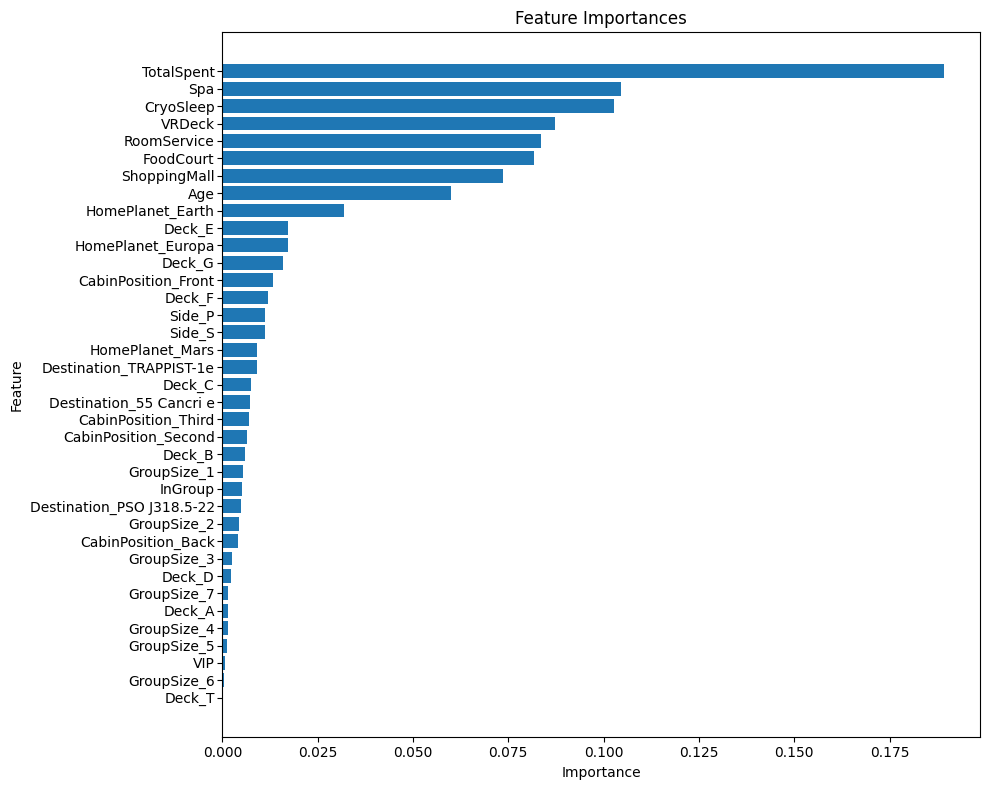

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh(rf_importance_df['Feature'], rf_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Random Forest Model')
plt.gca().invert_yaxis()
plt.tick_params(axis='y', pad=2)
plt.tight_layout()
plt.show()

---
### LGBM

Hyperparameter Tuning with GridSearchCV

In [81]:
params_grid_lgbm = {
    'clf__num_leaves': [31, 50, 70],
    'clf__max_depth': [-1, 10, 20, 30],
    'clf__learning_rate': [0.1, 0.01, 0.001],
    'clf__n_estimators': [100, 200, 300]
}

gs = GridSearchCV(estimator=pipelines['lgbm'], param_grid=params_grid_lgbm, cv=5, n_jobs=1, scoring='accuracy')

In [82]:
gs.fit(X_train, y_train)
lgbm_tuned = gs.best_estimator_
gs_best_estimators['lgbm'] = lgbm_tuned
joblib.dump(gs_best_estimators['lgbm'], '../models/lgbm_tuned.joblib')
gs_best_scores['lgbm'] = gs.best_score_

print(f'Best Hyperparameters:\n{gs.best_params_}')
print()
print(f'Best Accuracy Score:\n{gs.best_score_}')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters:
{'clf__learning_rate': 0.01, 'clf__max_depth': -1, 'clf__n_estimators': 300, 'clf__num_leaves': 31}

Best Accuracy Score:
0.811175020542317


In [83]:
feature_importances = lgbm_tuned.named_steps['clf'].feature_importances_
feature_names = lgbm_tuned.named_steps['col_transformer'].get_feature_names_out()
feature_names = [name.replace('cat_cols__', '').replace('num_cols__', '').replace('remainder__','') for name in feature_names]

lgbm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

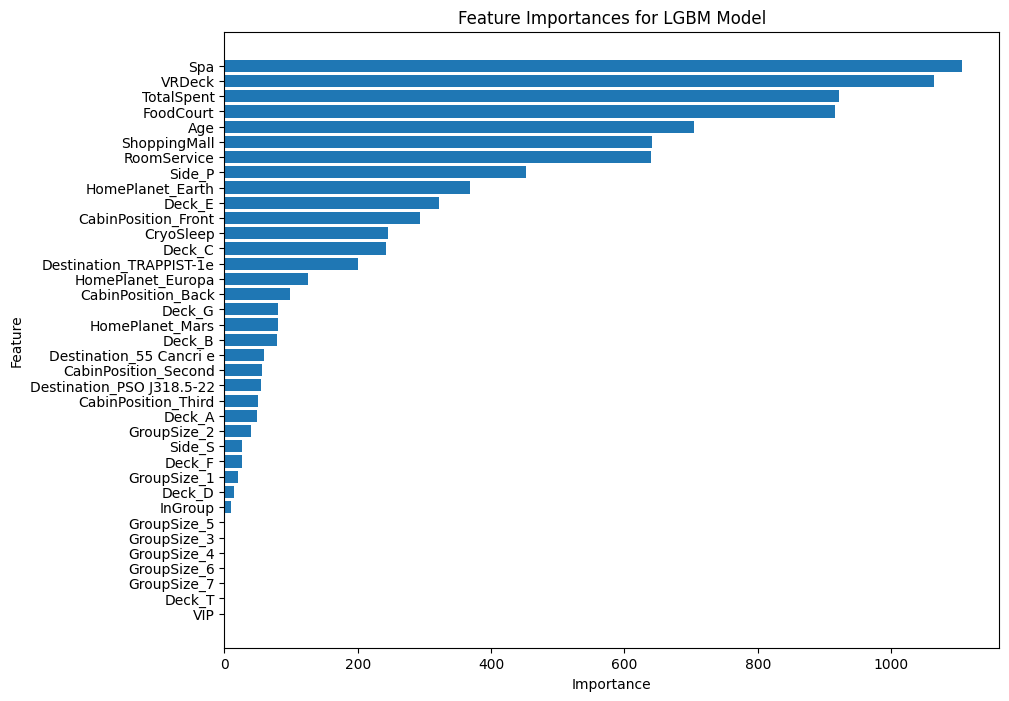

In [84]:
plt.figure(figsize=(10, 8))
plt.barh(lgbm_importance_df['Feature'], lgbm_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for LGBM Model')
plt.gca().invert_yaxis()
plt.show()

---
### XGBM

Hyperparameter tuning with GridSearchCV

In [76]:
params_grid_xgbm = {
    'clf__max_depth': [3, 6, 10],
    'clf__learning_rate': [0.1, 0.01, 0.001],
    'clf__n_estimators': [100, 200, 300],
    'clf__subsample': [0.6, 0.8, 1.0]
}

gs = GridSearchCV(estimator=pipelines['xgbm'], param_grid=params_grid_xgbm, cv=5, n_jobs=1, scoring='accuracy')

In [77]:
gs.fit(X_train, y_train)
xgbm_tuned = gs.best_estimator_
gs_best_estimators['xgbm'] = xgbm_tuned
joblib.dump(gs_best_estimators['xgbm'], '../models/xgbm_tuned.joblib')
gs_best_scores['xgbm'] = gs.best_score_

print(f'Best Hyperparameters:\n{gs.best_params_}')
print()
print(f'Best Accuracy Score:\n{gs.best_score_}')

Best Hyperparameters:
{'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 300, 'clf__subsample': 0.8}

Best Accuracy Score:
0.8121610517666392


In [78]:
feature_importances = xgbm_tuned.named_steps['clf'].feature_importances_
feature_names = xgbm_tuned.named_steps['col_transformer'].get_feature_names_out()
feature_names = [name.replace('cat_cols__', '').replace('num_cols__', '').replace('remainder__','') for name in feature_names]

xgbm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

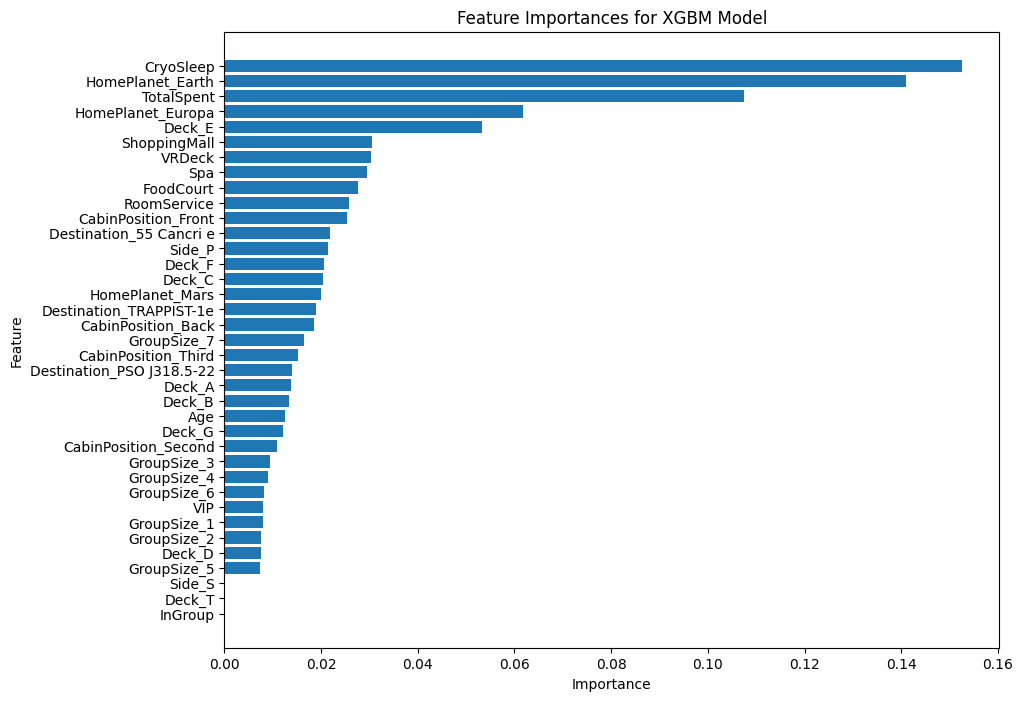

In [80]:
plt.figure(figsize=(10, 8))
plt.barh(xgbm_importance_df['Feature'], xgbm_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for XGBM Model')
plt.gca().invert_yaxis()
plt.show()

---
---
## Evaluation of tuned models with validation set

Random Forest

Test Scores (Classification):
------------------------------
F1: 0.78613
Roc auc: 0.78727

Classification Report:
----------------------
              precision    recall  f1-score   support

       False       0.78      0.80      0.79      1295
        True       0.80      0.78      0.79      1313

    accuracy                           0.79      2608
   macro avg       0.79      0.79      0.79      2608
weighted avg       0.79      0.79      0.79      2608


Confusion Matrix:
-----------------


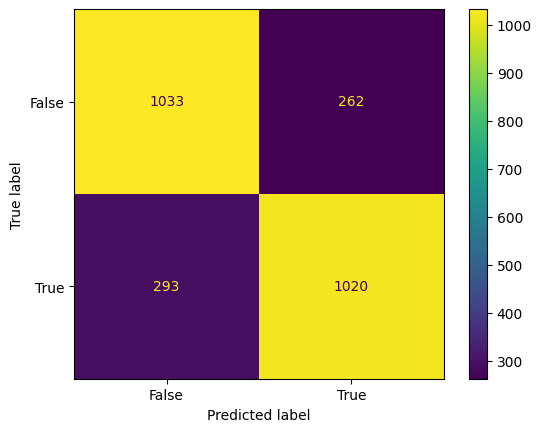

In [85]:
mlt.fit_test_evaluate(gs_best_estimators['rf'], X_train, y_train, X_val, y_val, metrics=['balanced_accuracy', 'f1', 'roc_auc'], print_report=True)

---
LGBM

Test Scores (Classification):
------------------------------
F1: 0.79625
Roc auc: 0.79128

Classification Report:
----------------------
              precision    recall  f1-score   support

       False       0.80      0.77      0.79      1295
        True       0.78      0.81      0.80      1313

    accuracy                           0.79      2608
   macro avg       0.79      0.79      0.79      2608
weighted avg       0.79      0.79      0.79      2608


Confusion Matrix:
-----------------


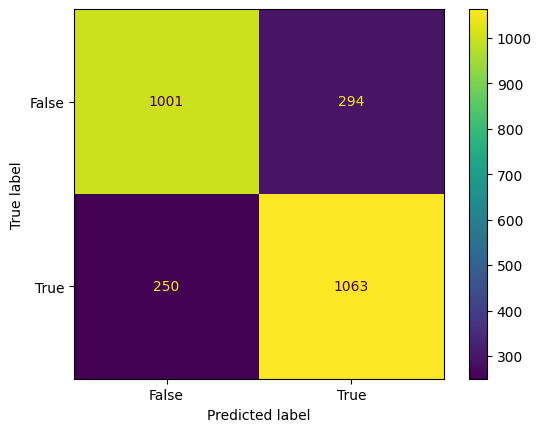

In [86]:
mlt.fit_test_evaluate(gs_best_estimators['lgbm'], X_train, y_train, X_val, y_val, metrics=['balanced_accuracy', 'f1', 'roc_auc'], print_report=True)

---
XGBM

Test Scores (Classification):
------------------------------
F1: 0.80179
Roc auc: 0.79625

Classification Report:
----------------------
              precision    recall  f1-score   support

       False       0.81      0.77      0.79      1295
        True       0.79      0.82      0.80      1313

    accuracy                           0.80      2608
   macro avg       0.80      0.80      0.80      2608
weighted avg       0.80      0.80      0.80      2608


Confusion Matrix:
-----------------


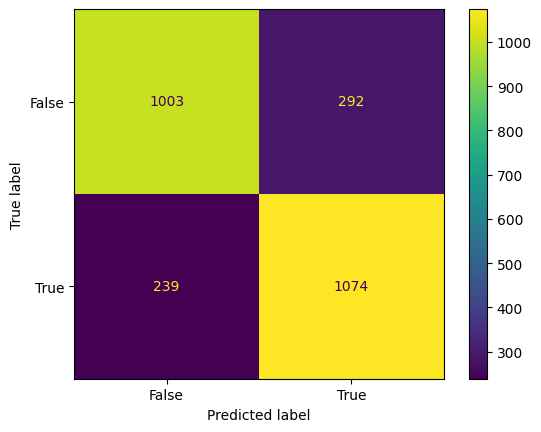

In [87]:
mlt.fit_test_evaluate(gs_best_estimators['xgbm'], X_train, y_train, X_val, y_val, metrics=['balanced_accuracy', 'f1', 'roc_auc'], print_report=True)

- Not quite hitting the 80% accuracy goal. Close but no cigar. 
- I will try to train on the entire dataset with no split and use each model to make a set of predictions and then submit all three.